# Модуль 2. Диффузионные модели. Часть 2.
##Семинар №3.Изучение особенностей диффузионных моделей с библиотекой accelerate.

### Цель занятия
Рассмотреть библиотеку accelerate для обучения, дообучения диффузионных моделей и поработать с ней.



---


### Перенос вашего кода в Accelerate

В этом руководстве подробно описано, как легко преобразовать существующий код PyTorch для использования Accelerate. Вы увидите, что, просто изменив несколько строк кода, Accelerate может творить чудеса и помочь вам с легкостью запускать свой код в распределенных системах.

# Что делать, чтобы ускорить или сократить использование памяти при тренировке модели?

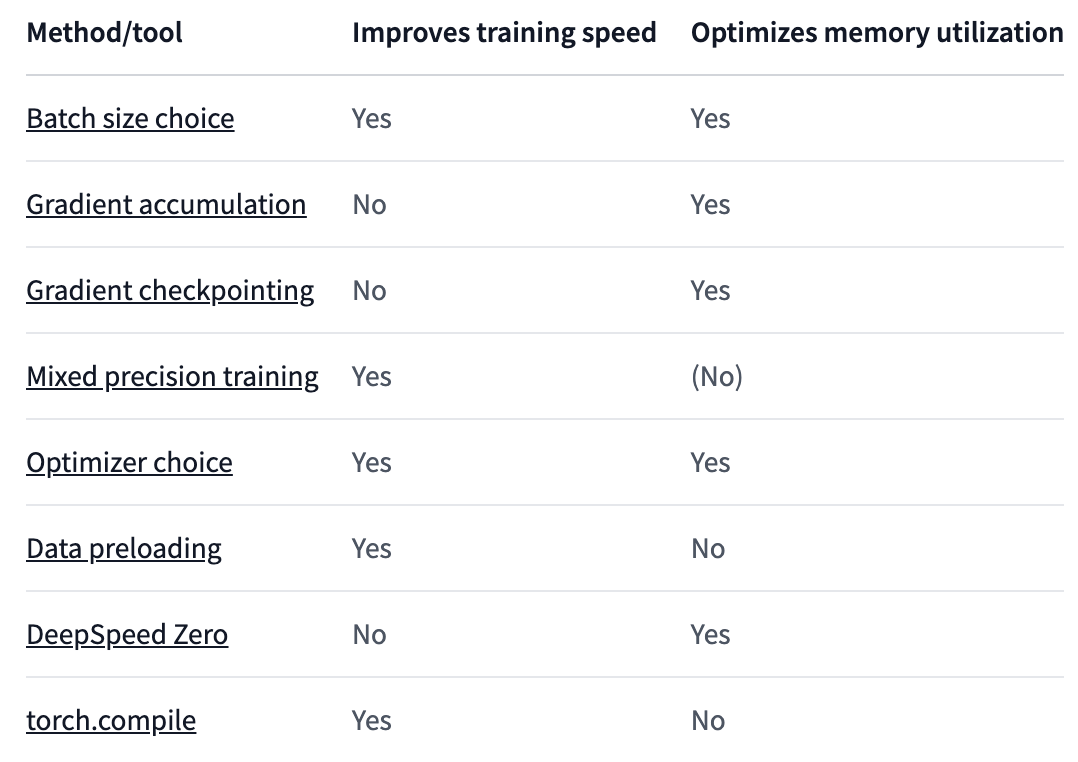

# Небольшая подводка зачем нужен accelerate

Есть много вариантов как уместить model, optimizer, gradients в gpu, можно держать копию model, optimizer, gradients в каждую карту, это назвывается DDP(distributed data parallel), оно хорошо и быстро работает когда у нас небольшая модель и мы можем держать копии в каждой карте.

![ddp](https://s2.loli.net/2022/01/28/WSAensMqjwHdOlR.png)

нам бы хотелось разложить модель по слоям на разные карты, а оптимайзер в каждую карту(просто чтобы экономить время на пересылку между картами), подробнее почитать про то как это работает в [статье](https://colossalai.org/docs/concepts/paradigms_of_parallelism/) и https://huggingface.co/transformers/v4.9.0/parallelism.html

![ds3](https://www.deepspeed.ai/assets/images/zero3-offload-memory-overview.png)

обязательно загляните по этой [ссылке](https://huggingface.co/docs/transformers/perf_train_gpu_many), чтобы преисполниться

# Список бэкэнов для распределенного обучения


1. Horovod: Это открытый проект от Uber, который использует алгоритмы обмена сообщениями для эффективного распределения работы. Horovod поддерживает TensorFlow, Keras, PyTorch и Apache MXNet.

2. NCCL (Nvidia Collective Communications Library): Это библиотека от Nvidia, которая оптимизирована для GPU и используется для межпроцессорной и межузловой связи.

3. DeepSpeed: Это библиотека от Microsoft, которая предлагает ряд оптимизаций для обучения больших моделей и датасетов.

4. PyTorch DDP (Distributed Data Parallel): Это встроенная библиотека в PyTorch для параллелизма данных, которая поддерживает многопоточность на уровне процесса.

  Megatron и многое другое


### Базовый цикл обучения

Для начала напишем очень простой цикл обучения PyTorch.

> Мы предполагаем, что `training_dataloader`, `model`, `optimizer`, `scheduler` и `loss_function` были определены заранее.

```
device = "cuda"
model.to(device)

for batch in training_dataloader:
    optimizer.zero_grad()
    inputs, targets = batch
    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs)
    loss = loss_function(outputs, targets)
    loss.backward()
    optimizer.step()
    scheduler.step()
```

### Добавляем Accelerate

Чтобы начать использовать Accelerate, сначала импортируйте и создайте экземпляр Accelerator:

```
from accelerate import Accelerator

accelerator = Accelerator()
```

Accelerator — это основная сила, позволяющая использовать все возможные варианты распределенного обучения!

#### Настройка правильного устройства

Класс Accelerator знает, на какое устройство можно в любой момент переместить любой объект PyTorch, поэтому вам следует изменить определение устройства, чтобы оно исходило из Accelerator:

```
- device = 'cuda'
+ device = accelerator.device
  model.to(device)
```

#### Подготовка объектов

Далее нужно передать все важные объекты, связанные с обучением, в `prepare()`. Accelerate позаботится о том, чтобы все было настроено в текущей среде, чтобы вы могли начать обучение:

```
model, optimizer, training_dataloader, scheduler = accelerator.prepare(
    model, optimizer, training_dataloader, scheduler
)
```

Эти объекты возвращаются в том же порядке, в котором они были отправлены. По умолчанию при использовании `device_placement=True` все объекты, которые можно отправить на нужное устройство, будут возвращены. Если вам нужно работать с данными, которые не передаются в [~Accelerator.prepare], но должны находиться на активном устройстве, вам следует передать устройство, созданное вами ранее.

> Accelerate подготавливает только объекты, которые наследуются от соответствующих классов PyTorch (например, torch.optim.Optimizer).

#### Изменение цикла обучения

Наконец, в цикле обучения необходимо изменить три строки кода. Классы `DataLoader` Accelerate по умолчанию автоматически обрабатывают размещение устройства, а для выполнения обратного прохода следует использовать метод `backward()`:

```
outputs = model(inputs)
loss = loss_function(outputs, targets)
accelerator.backward(loss)

# Вместо:
# inputs = inputs.to(device)
# targets = targets.to(device)
# outputs = model(inputs)
# loss = loss_function(outputs, targets)
# loss.backward()
```

Теперь ваш тренировочный цикл готов к использованию Accelerate!

#### Конечный код

Ниже приведена окончательная версия преобразованного кода:

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()

model, optimizer, training_dataloader, scheduler = accelerator.prepare(
    model, optimizer, training_dataloader, scheduler
)

for batch in training_dataloader:
    optimizer.zero_grad()
    inputs, targets = batch
    outputs = model(inputs)
    loss = loss_function(outputs, targets)
    accelerator.backward(loss)
    optimizer.step()
    scheduler.step()

Но как запустить этот код и заставить его использовать специальное оборудование, доступное для него?

Во-первых, следует переписать приведенный выше код в функцию и сделать ее вызываемой как скрипт. Например:

In [ ]:
from accelerate import Accelerator

def main():
    accelerator = Accelerator()

    model, optimizer, training_dataloader, scheduler = accelerator.prepare(
        model, optimizer, training_dataloader, scheduler
    )

    for batch in training_dataloader:
        optimizer.zero_grad()
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        accelerator.backward(loss)
        optimizer.step()
        scheduler.step()

if __name__ == "__main__":
    main()

#### Использование запуска Accelerate

В Accelerate есть специальная команда CLI, которая поможет вам запустить код в вашей системе посредством accelerate launch. Эта команда охватывает все различные команды, необходимые для запуска вашего скрипта на различных платформах, и вам не нужно запоминать, что представляет собой каждая из них.

Можно быстро запустить свой скрипт, используя:

In [ ]:
accelerate launch {script_name.py} --arg1 --arg2 ...

Просто поместите `accelerate launch` в начало вашей команды, а затем передайте дополнительные аргументы и параметры в ваш скрипт, как обычно.

Здесь также можно изменить все ожидаемые переменные среды. Например, вот как использовать `accelerate launch` с одним GPU:

In [ ]:
CUDA_VISIBLE_DEVICES="0" accelerate launch {script_name.py} --arg1 --arg2 ...

Вы также можете использовать `accelerate launch` без предварительного конфига accelerate, но вам может потребоваться вручную передать правильные параметры конфигурации. В этом случае Accelerate примет за вас некоторые решения по гиперпараметрам, например, если GPU доступны, он будет использовать их все по умолчанию без смешанной точности. Вот как можно использовать все GPU и тренироваться с отключенной смешанной точностью:

In [ ]:
accelerate launch --multi_gpu {script_name.py} {--arg1} {--arg2} ...

Или указав количество используемых GPU:

In [ ]:
accelerate launch --num_processes=2 {script_name.py} {--arg1} {--arg2} ...

Чтобы получить более конкретную информацию, вам следует передать необходимые параметры самостоятельно. Например, вот как можно запустить тот же сценарий на двух графических процессорах со смешанной точностью, избегая при этом всех предупреждений:

In [ ]:
accelerate launch --multi_gpu --mixed_precision=fp16 --num_processes=2 {script_name.py} {--arg1} {--arg2} ...

Чтобы получить полный список параметров, которые вы можете передать, запустите:

In [ ]:
accelerate launch -h

Для визуализации этой разницы более ранний запуск `accelerate` на нескольких GPU с torchrun выглядел бы примерно так:

In [ ]:
MIXED_PRECISION="fp16" torchrun --nproc_per_node=2 --num_machines=1 {script_name.py} {--arg1} {--arg2} ...

Вы также можете запустить свой скрипт, используя CLI запуск в качестве самого модуля Python, что позволяет передавать другие варианты поведения запуска, специфичные для Python. Для этого используйте `accelerate.commands.launch` вместо «accelerate launch»:

In [ ]:
python -m accelerate.commands.launch --num_processes=2 {script_name.py} {--arg1} {--arg2}

Если вы хотите выполнить сценарий с любыми другими флагами python, вы можете передать их так же, как и -m, например, как в приведенном ниже примере, включающем небуферизованный стандартный вывод и стандартный поток ошибок:

In [ ]:
python -u -m accelerate.commands.launch --num_processes=2 {script_name.py} {--arg1} {--arg2}

#### Почему вы всегда должны использовать accelerate config

Почему это настолько полезно, что вам всегда нужно запускать `accelerate config`?

Помните тот предыдущий вызов `accelerate launch`, а также запуск `torchrun`? После настройки, чтобы запустить этот скрипт с необходимыми частями, вам просто нужно сразу использовать `accelerate launch`, не передавая ничего больше:

In [ ]:
accelerate launch {script_name.py} {--arg1} {--arg2} ...

#### Пользовательские конфигурации

Как кратко упоминалось ранее, ускоренный запуск следует в основном использовать путем объединения настроек набора, созданных с помощью команды ускорения конфигурации. Эти конфигурации сохраняются в файле `default_config.yaml` в папке кэша для `Accelerate`. Эта папка кэша находится по адресу (в порядке убывания приоритета):

К содержимому вашей переменной среды `HF_HOME` добавлен суффикс ускорения.
Если он не существует, к содержимому вашей переменной среды `XDG_CACHE_HOME` добавляется суффикс `huggingface/accelerate`.
Если и его не существует, папка `~/.cache/huggingface/accelerate`.
Чтобы иметь несколько конфигураций, флаг `--config_file` можно передать команде ускоренного запуска вместе с расположением пользовательского файла `yaml`.

Пример `yaml` может выглядеть примерно так для двух GPU на одной машине с использованием `fp16` для смешанной точности:

In [ ]:
compute_environment: LOCAL_MACHINE
deepspeed_config: {}
distributed_type: MULTI_GPU
fsdp_config: {}
machine_rank: 0
main_process_ip: null
main_process_port: null
main_training_function: main
mixed_precision: fp16
num_machines: 1
num_processes: 2
use_cpu: false

Запуск сценария из местоположения этого пользовательского файла `yaml` выглядит следующим образом:

In [ ]:
accelerate launch --config_file {path/to/config/my_config_file.yaml} {script_name.py} {--arg1} {--arg2} ...

## Запуск обучения на нескольких узлах

### Настройка среды

Прежде чем можно будет выполнить какое-либо обучение, в системе должен существовать файл accelerate config. Обычно это можно сделать, выполнив в терминале следующую команду:
```
accelerate config
```
Однако, если общие настройки по умолчанию подходят и вы не используете TPU, у ускорения есть утилита для быстрой записи конфигурации вашего GPU в файл конфигурации через `write_basic_config`.

Следующая ячейка перезапустит Jupyter после записи конфигурации, поскольку для этого был вызван код CUDA. CUDA не может быть инициализирован более одного раза (один раз для ноутбуков с одним GPU, используемых по умолчанию, а затем еще раз при вызове `notebook_launcher`). Можно выполнять отладку в блокноте и вызывать CUDA, но помните, что для окончательного обучения необходимо выполнить полную очистку и перезапуск, как показано ниже:



In [ ]:
!pip install timm accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.8 MB/s eta 0:00:00


In [ ]:
# import os
# from accelerate.utils import write_basic_config
# write_basic_config() # Write a config file
# os._exit(00) # Restart the notebook

### Подготовка датасета и модели

Далее нужно подготовить набор данных. Как упоминалось ранее, при подготовке `DataLoaders` и модели следует проявлять особую осторожность, чтобы убедиться, что ни на один GPU данные внутри не переносятся.

Если вы это сделаете, рекомендуется поместить этот конкретный код в функцию и вызывать ее из интерфейса запуска ноутбука, который будет показан позже.

Убедитесь, что датасет загружен в соответствии с инструкциями [здесь](https://github.com/huggingface/accelerate/tree/main/examples#simple-vision-example).

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!tar -xzf images.tar.gz

--2023-09-26 18:06:06--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-09-26 18:06:07--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-09-26 18:06:08--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-str

In [ ]:
import os, re, torch, PIL
import numpy as np

from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, RandomResizedCrop, Resize, ToTensor

from accelerate import Accelerator
from accelerate.utils import set_seed
from timm import create_model

Сначала мы создадим функцию для извлечения имени класса на основе файла:

In [ ]:
import os
data_dir = "/content/images"
fnames = os.listdir(data_dir)
fname = fnames[0]
print(fname)

Maine_Coon_131.jpg


В данном случае метка — `Maine_Coon`:

In [ ]:
!pip install torchvision

In [ ]:
import re
def extract_label(fname):
    stem = fname.split(os.path.sep)[-1]
    return re.search(r"^(.*)_\d+\.jpg$", stem).groups()[0]

In [ ]:
extract_label(fname)

'Maine_Coon'

Дальше создаем класс `Dataset`

In [ ]:
class PetsDataset(Dataset):
    def __init__(self, file_names, image_transform=None, label_to_id=None):
        self.file_names = file_names
        self.image_transform = image_transform
        self.label_to_id = label_to_id

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        fname = self.file_names[idx]
        raw_image = PIL.Image.open(fname)
        image = raw_image.convert("RGB")
        if self.image_transform is not None:
            image = self.image_transform(image)
        label = extract_label(fname)
        if self.label_to_id is not None:
            label = self.label_to_id[label]
        return {"image": image, "label": label}

И создадим наш набор данных

In [ ]:
# Захватываем все имена файлов изображений
fnames = [
    os.path.join(data_dir, fname)
    for fname in fnames
    if fname.endswith(".jpg")
]

# Создаем метки
all_labels = [
    extract_label(fname)
    for fname in fnames
]
id_to_label = list(set(all_labels))
id_to_label.sort()
label_to_id = {lbl: i for i, lbl in enumerate(id_to_label)}



> Примечание: это будет храниться внутри функции, поскольку мы будем устанавливать `seed` во время обучения.



In [ ]:
def get_dataloaders(batch_size:int=64):
    "Создает множество dataloaders с batch_size"
    random_perm = np.random.permutation(len(fnames))
    cut = int(0.8 * len(fnames))
    train_split = random_perm[:cut]
    eval_split = random_perm[:cut]

    # Для обучения мы используемы обычный RandomResizedCrop
    train_tfm = Compose([
        RandomResizedCrop((224, 224), scale=(0.5, 1.0)),
        ToTensor()
    ])
    train_dataset = PetsDataset(
        [fnames[i] for i in train_split],
        image_transform=train_tfm,
        label_to_id=label_to_id
    )

    # Для eval мы используем детерминированный Resize
    eval_tfm = Compose([
        Resize((224, 224)),
        ToTensor()
    ])
    eval_dataset = PetsDataset(
        [fnames[i] for i in eval_split],
        image_transform=eval_tfm,
        label_to_id=label_to_id
    )

    # Создание экземпляров dataloader
    train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        batch_size=batch_size,
        num_workers=4
    )
    eval_dataloader = DataLoader(
        eval_dataset,
        shuffle=False,
        batch_size=batch_size*2,
        num_workers=4
    )
    return train_dataloader, eval_dataloader

### Написание функции обучения

Теперь мы можем построить наш цикл обучения. `notebook_launcher` работает, передавая функцию для вызова, которая будет выполняться в распределенной системе.

Вот базовый цикл обучения для нашей задачи классификации животных:

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
def training_loop(mixed_precision="fp16", seed:int=42, batch_size:int=64):
    set_seed(seed)
    # Создаем accelerator
    accelerator = Accelerator(mixed_precision=mixed_precision)
    # Создаем dataloaders
    train_dataloader, eval_dataloader = get_dataloaders(batch_size)

    # Создаем экземпляр модели (здесь мы строим модель так, чтобы начальное число также контролировало новые инициализации веса)
    model = create_model("resnet50d", pretrained=True, num_classes=len(label_to_id))

    # Замораживаем базовую модель
    for param in model.parameters():
        param.requires_grad=False
    for param in model.get_classifier().parameters():
        param.requires_grad=True

    # Нормализуем батчи изображений чтобы было более быстро
    mean = torch.tensor(model.default_cfg["mean"])[None, :, None, None]
    std = torch.tensor(model.default_cfg["std"])[None, :, None, None]

    # Чтобы сделать эту константу доступной на активном устройстве, мы устанавливаем ее на accelerator устройство.
    mean = mean.to(accelerator.device)
    std = std.to(accelerator.device)

    # Создаем экземпляр оптимизатора
    optimizer = torch.optim.Adam(params=model.parameters(), lr = 3e-2/25)

    # Создаем learning rate scheduler
    lr_scheduler = OneCycleLR(
        optimizer=optimizer,
        max_lr=3e-2,
        epochs=5,
        steps_per_epoch=len(train_dataloader)
    )

    # Подготовка
    # Нет определенного порядка, который нужно запомнить,
    # нам просто нужно распаковать объекты в том же порядке,
    # в котором мы указали их в методе подготовки..
    model, optimizer, train_dataloader, eval_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader, lr_scheduler
    )

    # Теперь тренируем модель
    for epoch in range(5):
        model.train()
        for step, batch in enumerate(train_dataloader):
            # Мы могли бы избежать этой строки, поскольку установили accelerator с помощью device_placement=True.
            batch = {k: v.to(accelerator.device) for k, v in batch.items()}
            inputs = (batch["image"] - mean) / std
            outputs = model(inputs)
            loss = torch.nn.functional.cross_entropy(outputs, batch["label"])
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        model.eval()
        accurate = 0
        num_elems = 0
        for _, batch in enumerate(eval_dataloader):
            # Мы могли бы избежать этой строки, поскольку установили accelerator с помощью device_placement=True.
            batch = {k: v.to(accelerator.device) for k, v in batch.items()}
            inputs = (batch["image"] - mean) / std
            with torch.no_grad():
                outputs = model(inputs)
            predictions = outputs.argmax(dim=-1)
            accurate_preds = accelerator.gather(predictions) == accelerator.gather(batch["label"]) #для сбора предсказаний из разных устройств
            num_elems += accurate_preds.shape[0]
            accurate += accurate_preds.long().sum()

        eval_metric = accurate.item() / num_elems
        # Используем accelerator.print чтобы вывести только на главном процессе.
        accelerator.print(f"epoch {epoch}: {100 * eval_metric:.2f}") #для печати только на главном устройстве

Все, что осталось, — это использовать `notebook_launcher`.

Мы передаем функцию, аргументы (в виде кортежа) и количество процессов для обучения. (Дополнительную информацию см. в [документации](https://huggingface.co/docs/accelerate/package_reference/launchers#accelerate.notebook_launcher))

In [ ]:
from accelerate import notebook_launcher

In [ ]:
args = ("fp16", 42, 64)
notebook_launcher(training_loop, args, num_processes=2)

Launching training on one GPU.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 0: 85.88
epoch 1: 87.82
epoch 2: 93.83
epoch 3: 96.96
epoch 4: 97.41


## Распределенный inference с Accelerate

Распределенный inference — распространенный вариант использования, когда вы хотите реализовать запуск модели на нескольких GPU. Пользователи часто хотят отправить несколько разных запросов, каждый на отдельный графический процессор, а затем получить результаты обратно.

### Проблема

Обычно при этом пользователи отправляют модель на определенное устройство, чтобы загрузить ее из CPU, а затем перемещают каждый промпт на другое устройство.

Базовый пайплайн, использующий библиотеку `diffusers`, может выглядеть примерно так:

In [ ]:
import torch
import torch.distributed as dist
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)

Затем следует выполнение вывода на основе конкретного промпта:

In [ ]:
def run_inference(rank, world_size):
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    pipe.to(rank)

    if torch.distributed.get_rank() == 0:
        prompt = "a dog"
    elif torch.distributed.get_rank() == 1:
        prompt = "a cat"

    result = pipe(prompt).images[0]
    result.save(f"result_{rank}.png")

Можно заметить, что нам приходится проверять ранг, чтобы знать, какой промпт отправить, что может быть немного утомительно.

Тогда пользователь также может подумать, что с `Accelerate` использование `Accelerator` для подготовки `dataloader` для такой задачи также может быть простым способом справиться с этим.

Сможет ли оно справиться с этим? Да. Однако добавляет ли это ненужный дополнительный код: тоже да.

### Решение


С помощью `Accelerate` мы можем упростить этот процесс, используя контекстный менеджер `Accelerator.split_between_processes()` (который также существует в `PartialState` и `AcceleratorState`). Эта функция автоматически разделит любые данные, которые вы ей передаете (будь то промпт, набор тензоров, словарь предыдущих данных и т. д.) по всем процессам (с возможностью дополнения), чтобы вы могли их сразу использовать.

Давайте перепишем приведенный выше пример, используя этот контекстный менеджер:

In [ ]:
from accelerate import PartialState  # Может быть Accelerator или AcceleratorState
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
distributed_state = PartialState()
pipe.to(distributed_state.device)

# Предполагаем
with distributed_state.split_between_processes(["a dog", "a cat"]) as prompt:
    result = pipe(prompt).images[0]
    result.save(f"result_{distributed_state.process_index}.png")

А затем, чтобы запустить код, мы можем использовать `Accelerate`:

Если вы создали файл конфигурации для использования с помощью `accelerate config`:

In [ ]:
accelerate launch distributed_inference.py

Если у вас есть конкретный файл конфигурации, который вы хотите использовать:

In [ ]:
accelerate launch --config_file my_config.json distributed_inference.py

Или, если вы не хотите создавать какие-либо файлы конфигурации и запускать их на двух GPU:

In [ ]:
accelerate launch --num_processes 2 distributed_inference.py

Теперь мы довольно легко сократили шаблонный код, необходимый для разделения этих данных, на несколько строк кода.

Но что, если у нас будет странное распределение подсказок по графическим процессорам? Например, что, если у нас есть 3 промпта, но только 2 GPU?

Под управлением контекстного менеджера первый GPU получит первые два запроса, а второй GPU — третий, гарантируя, что все запросы будут разделены и не потребуется никаких дополнительных затрат.

Однако что, если мы затем захотим что-то сделать с результатами всех GPU? (Скажем, собрать их все и выполнить какую-то постобработку). Вы можете передать `apply_padding=True`, чтобы гарантировать, что списки промптов заполняются до одинаковой длины, а дополнительные данные берутся из последней выборки. Таким образом, все GPU будут получать одинаковое количество запросов, и вы сможете собрать результаты.

Например:

In [ ]:
from accelerate import PartialState  # Может также быть Accelerator или AcceleratorState
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
distributed_state = PartialState()
pipe.to(distributed_state.device)

# Предполагаем два процесса
with distributed_state.split_between_processes(["a dog", "a cat", "a chicken"], apply_padding=True) as prompt:
    result = pipe(prompt).images

На первом GPU промптами будут ["a dog", "a cat"], а на втором GPU - ["a chicken", "a chicken"]. Обязательно отбросьте окончательный образец, так как он будет копией предыдущего.

### Вывод

В этом блокноте показано, как выполнять распределенное обучение изнутри Jupyter Notebook. Некоторые ключевые замечания, которые следует запомнить:

* Обязательно сохраните любой код, использующий CUDA (или импорт CUDA) для функции, передаваемой в `notebook_launcher`.
* Установите `num_processes` как количество устройств, используемых для обучения (например, количество GPU, CPU, TPU и т.д.).